20250227

**VdHSpecificModel is the latest version of the model trained ONLY with the variables present in the Valle de las Higueras dataset.**


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report


In [2]:
#Load data
df = pd.read_excel('/home/dsg/VORTEX_FINAL/PRODUCTION/DATA/processed/final_input_data.xlsx', engine='openpyxl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1778 non-null   int64  
 1   Al          1778 non-null   float64
 2   Si          1778 non-null   float64
 3   P           1778 non-null   float64
 4   S           1778 non-null   float64
 5   Cl          1778 non-null   float64
 6   K           1778 non-null   float64
 7   Ca          1778 non-null   float64
 8   Sc          1778 non-null   float64
 9   Ti          1778 non-null   float64
 10  V           1778 non-null   float64
 11  Cr          1778 non-null   float64
 12  Mn          1778 non-null   float64
 13  Fe          1778 non-null   float64
 14  Co          1778 non-null   float64
 15  Ni          1778 non-null   float64
 16  Cu          1778 non-null   float64
 17  Zn          1778 non-null   float64
 18  Ga          1778 non-null   float64
 19  Ge          1778 non-null  

In [3]:
data = df.drop(['rand','Unnamed: 0'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1778 non-null   float64
 1   Si      1778 non-null   float64
 2   P       1778 non-null   float64
 3   S       1778 non-null   float64
 4   Cl      1778 non-null   float64
 5   K       1778 non-null   float64
 6   Ca      1778 non-null   float64
 7   Sc      1778 non-null   float64
 8   Ti      1778 non-null   float64
 9   V       1778 non-null   float64
 10  Cr      1778 non-null   float64
 11  Mn      1778 non-null   float64
 12  Fe      1778 non-null   float64
 13  Co      1778 non-null   float64
 14  Ni      1778 non-null   float64
 15  Cu      1778 non-null   float64
 16  Zn      1778 non-null   float64
 17  Ga      1778 non-null   float64
 18  Ge      1778 non-null   float64
 19  As      1778 non-null   float64
 20  Se      1778 non-null   float64
 21  Br      1778 non-null   float64
 22  

In [4]:
#Target distribution

#CT== can_tintorer
#PDLC== aliste
#PCM== encinasola
target = data['Site'].value_counts()
target

Site
CT      828
PDLC    511
PCM     439
Name: count, dtype: int64

In [5]:
fvs = pd.read_excel('/home/dsg/VORTEX_FINAL/PRODUCTION/DATA/processed/final_validation_set.xlsx')
fvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      178 non-null    float64
 1   Si      178 non-null    float64
 2   P       178 non-null    float64
 3   S       178 non-null    float64
 4   Cl      178 non-null    float64
 5   K       178 non-null    float64
 6   Ca      178 non-null    float64
 7   Sc      178 non-null    float64
 8   Ti      178 non-null    float64
 9   V       178 non-null    float64
 10  Cr      178 non-null    float64
 11  Mn      178 non-null    float64
 12  Fe      178 non-null    float64
 13  Co      178 non-null    float64
 14  Ni      178 non-null    float64
 15  Cu      178 non-null    float64
 16  Zn      178 non-null    float64
 17  Ga      178 non-null    float64
 18  Ge      178 non-null    float64
 19  As      178 non-null    float64
 20  Se      178 non-null    float64
 21  Br      178 non-null    float64
 22  Rb

In [6]:
# Looking for common ids

# 1. Crear data_trainning eliminando las filas de 'data' cuyos 'id' están en 'vs1'
data_trainning = data[~data['id'].isin(fvs['id'])]

# 2. Reiniciar los índices si es necesario
data_trainning.reset_index(drop=True, inplace=True)

# 3. Verificar los resultados
print('Data original shape:', data.shape)
print('Validation set shape:', fvs.shape)
print('Training data shape:', data_trainning.shape)

# 4. Opcionalmente, verificar que no hay ids de fvs en data_trainning
common_ids = set(data_trainning['id']).intersection(set(fvs['id']))
print('Number of common ids (should be 0):', len(common_ids))

Data original shape: (1778, 46)
Validation set shape: (178, 47)
Training data shape: (1600, 46)
Number of common ids (should be 0): 0


In [7]:
data_trainning.Site.value_counts()

Site
CT      752
PDLC    457
PCM     391
Name: count, dtype: int64

In [8]:
fvs.Site.value_counts()

Site
CT      76
PDLC    54
PCM     48
Name: count, dtype: int64

#### Filtering features 

We perform a feature selection task based on the specific features of the dataset.

In [9]:
trainning_features = ['Al', 'Si', 'P', 'S', 'Cl', 'K',
                      'Ti', 'V', 'Cr', 'Mn','Fe', 'Co', 
                      'Ni','Cu','Zn', 'As', 'Rb', 
                      'Sr', 'Zr', 'Site']

data_trainning = data_trainning[trainning_features] 
fvs = fvs[trainning_features]

In [10]:
data_trainning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1600 non-null   float64
 1   Si      1600 non-null   float64
 2   P       1600 non-null   float64
 3   S       1600 non-null   float64
 4   Cl      1600 non-null   float64
 5   K       1600 non-null   float64
 6   Ti      1600 non-null   float64
 7   V       1600 non-null   float64
 8   Cr      1600 non-null   float64
 9   Mn      1600 non-null   float64
 10  Fe      1600 non-null   float64
 11  Co      1600 non-null   float64
 12  Ni      1600 non-null   float64
 13  Cu      1600 non-null   float64
 14  Zn      1600 non-null   float64
 15  As      1600 non-null   float64
 16  Rb      1600 non-null   float64
 17  Sr      1600 non-null   float64
 18  Zr      1600 non-null   float64
 19  Site    1600 non-null   object 
dtypes: float64(19), object(1)
memory usage: 250.1+ KB


#### Creating our Classification function:


In [11]:
X = data_trainning.drop(['Site'], axis=1)
y = data_trainning['Site']

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1600 non-null   float64
 1   Si      1600 non-null   float64
 2   P       1600 non-null   float64
 3   S       1600 non-null   float64
 4   Cl      1600 non-null   float64
 5   K       1600 non-null   float64
 6   Ti      1600 non-null   float64
 7   V       1600 non-null   float64
 8   Cr      1600 non-null   float64
 9   Mn      1600 non-null   float64
 10  Fe      1600 non-null   float64
 11  Co      1600 non-null   float64
 12  Ni      1600 non-null   float64
 13  Cu      1600 non-null   float64
 14  Zn      1600 non-null   float64
 15  As      1600 non-null   float64
 16  Rb      1600 non-null   float64
 17  Sr      1600 non-null   float64
 18  Zr      1600 non-null   float64
dtypes: float64(19)
memory usage: 237.6 KB


In [13]:
y.value_counts()

Site
CT      752
PDLC    457
PCM     391
Name: count, dtype: int64

#### Data Aumentagtion of minority classes (SMOTE)
We carry out the Synthetic Minority Oversampling Technique

Site
PDLC    752
CT      752
PCM     752
Name: count, dtype: int64

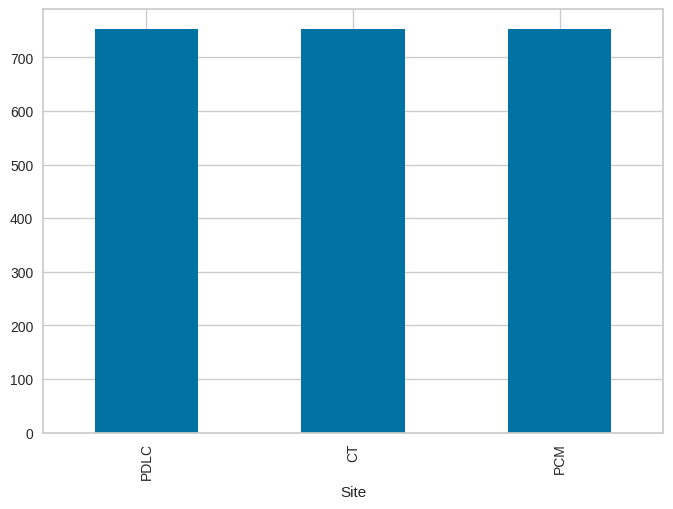

In [14]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

In [15]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['Site'] = y_smote

In [16]:
# Final dataset shape after resampling
smote_data.shape
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      2256 non-null   float64
 1   Si      2256 non-null   float64
 2   P       2256 non-null   float64
 3   S       2256 non-null   float64
 4   Cl      2256 non-null   float64
 5   K       2256 non-null   float64
 6   Ti      2256 non-null   float64
 7   V       2256 non-null   float64
 8   Cr      2256 non-null   float64
 9   Mn      2256 non-null   float64
 10  Fe      2256 non-null   float64
 11  Co      2256 non-null   float64
 12  Ni      2256 non-null   float64
 13  Cu      2256 non-null   float64
 14  Zn      2256 non-null   float64
 15  As      2256 non-null   float64
 16  Rb      2256 non-null   float64
 17  Sr      2256 non-null   float64
 18  Zr      2256 non-null   float64
 19  Site    2256 non-null   object 
dtypes: float64(19), object(1)
memory usage: 352.6+ KB


In [17]:
# Experiment setup 

experiment = setup(data=smote_data, target= 'Site',train_size=0.8, session_id=123)

,Description,Value
0,Session id,123
1,Target,Site
2,Target type,Multiclass
3,Target mapping,"CT: 0, PCM: 1, PDLC: 2"
4,Original data shape,"(2256, 20)"
5,Transformed data shape,"(2256, 20)"
6,Transformed train set shape,"(1804, 20)"
7,Transformed test set shape,"(452, 20)"
8,Numeric features,19
9,Preprocess,True


In [18]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [19]:
#destilled random forest (drf)
vdhrf = create_model('rf',n_estimators=200,
                  min_samples_leaf=5,
                  class_weight="balanced", 
                  criterion='entropy',
                  random_state=42)

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9282,0.9282,0.9311,0.9280
1,0.9613,0.9613,0.9623,0.9615
2,0.9779,0.9779,0.9788,0.9778
3,0.9613,0.9613,0.9619,0.9613
4,0.9389,0.9389,0.9397,0.9388
5,0.9333,0.9333,0.9332,0.9330
6,0.9722,0.9722,0.9722,0.9722
7,0.9500,0.9500,0.9502,0.9500
8,0.9111,0.9111,0.9118,0.9110


In [20]:
tuned_model = tune_model(vdhrf, n_iter=10, 
                         tuner_verbose=True, 
                         optimize='F1', 
                         custom_grid = 
                         {'criterion': ['entropy'],              
                          'min_samples_leaf':[5, 10, 15, 20, 25, 30],
                           'n_estimators':[10,50,100,200]})

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9392,0.9392,0.9399,0.9393
1,0.9669,0.9669,0.9671,0.9668
2,0.9779,0.9779,0.9788,0.9778
3,0.9669,0.9669,0.9671,0.9668
4,0.9389,0.9389,0.9397,0.9388
5,0.9222,0.9222,0.9232,0.9218
6,0.9611,0.9611,0.9612,0.9608
7,0.9500,0.9500,0.9509,0.9501
8,0.9222,0.9222,0.9229,0.9222


Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Model Calibration:
This function calibrates the probability of a given estimator using isotonic or logistic regression. The output of this function is a score grid with CV scores by fold.
By default function uses Logistic regression model to transform probabilities.
We chose this method to take into account the following library documentation [warning](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.calibrate_model) and avoid overfitting. 


In [21]:
cal_model = calibrate_model(tuned_model, method='sigmoid')  # Usa el modelo entrenado
cal_model

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9227,0.9227,0.9260,0.9226
1,0.9558,0.9558,0.9572,0.9560
2,0.9724,0.9724,0.9735,0.9721
3,0.9558,0.9558,0.9579,0.9557
4,0.9389,0.9389,0.9397,0.9388
5,0.9389,0.9389,0.9390,0.9388
6,0.9611,0.9611,0.9612,0.9609
7,0.9444,0.9444,0.9449,0.9445
8,0.9000,0.9000,0.8999,0.8998


CalibratedClassifierCV(cv=5, ensemble=True,
                       estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_samples_leaf=5,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        monotonic_cst=None,
                                                        n_estimators=50,
                                                        n_jobs=-1,
                                                        oob_score=False,
                                                        random_state=42,
                                                        verbose=0,
                                                        warm_start=False),
                       method='sigmoid', n_jobs=None)

In [22]:
X_train = get_config(variable="X_train")
y_train = get_config(variable="y_train")
X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")
y_test.value_counts()

Site
PCM     151
PDLC    151
CT      150
Name: count, dtype: int64

In [23]:
final_model = finalize_model(cal_model)


In [24]:
unseen_predictions = predict_model(final_model, data=fvs)
unseen_predictions

,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9270,0.9270,0.9282,0.9269


,Al,Si,P,S,Cl,K,Ti,V,Cr,Mn,...,Ni,Cu,Zn,As,Rb,Sr,Zr,Site,prediction_label,prediction_score
0,16.967108,58.748379,16.361971,0.471474,1.349358,0.005982,0.244552,0.110844,0.333959,0.005982,...,0.005982,0.000598,0.000598,0.000598,0.000598,0.029355,0.018229,PDLC,PDLC,0.9375
1,31.785463,29.897738,30.298309,0.986918,1.875399,0.833437,0.273988,0.407125,0.624654,0.005310,...,0.005310,0.000531,0.000531,0.000531,0.000531,0.008848,0.006868,PDLC,PDLC,0.8930
2,38.207870,17.721268,37.159813,0.472849,1.671586,0.005075,0.318398,0.005075,0.496039,0.005075,...,0.005075,0.000508,0.000508,0.030483,0.000508,0.000508,0.007399,PDLC,PDLC,0.9905
3,43.829479,13.649417,32.084663,0.268403,0.976809,0.005196,0.062420,0.005196,0.051067,0.005196,...,0.004073,6.039982,0.032030,0.004231,0.000520,0.000520,0.004785,PDLC,PDLC,0.9876
4,10.076868,46.039585,14.790862,0.824680,3.853663,0.006428,0.736598,0.006428,0.160223,0.006428,...,0.006428,0.065449,0.000643,0.000643,0.000643,0.075932,0.028680,PDLC,CT,0.7122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,29.133850,12.200644,28.188839,0.339457,1.678676,0.985179,0.517829,0.005385,0.322604,0.005385,...,0.007248,0.193464,0.012025,0.000538,0.004032,0.573649,0.015053,CT,CT,0.8085
174,29.224028,39.126438,12.966257,0.540606,1.775522,1.965273,0.427249,0.107501,0.180761,0.005863,...,0.005863,0.009873,0.004484,0.027077,0.000586,0.159999,0.004692,CT,CT,0.9696
175,1.973777,14.026845,0.234887,18.849106,1.987404,0.007057,0.049239,0.007057,0.069079,2.597719,...,0.007057,8.340240,0.677386,0.000706,0.003220,0.000706,0.000706,CT,PDLC,0.6278
176,26.421036,12.490799,36.550430,0.477651,2.640254,1.098620,0.652768,0.235262,0.261720,0.005430,...,0.005430,0.110237,0.010964,0.150613,0.000543,0.083543,0.012679,CT,CT,0.9481


In [25]:
#Final model evaluation in the final validation set
y_true = unseen_predictions['Site']
y_pred = unseen_predictions['prediction_label']
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep_vs1.to_csv('./TABLES/20250227_fvsClassReportVdHSpecific.csv')
class_rep

,precision,recall,f1-score,support
CT,0.900000,0.947368,0.923077,76.000000
PCM,0.954545,0.875000,0.913043,48.000000
PDLC,0.944444,0.944444,0.944444,54.000000
accuracy,0.926966,0.926966,0.926966,0.926966
macro avg,0.932997,0.922271,0.926855,178.000000
weighted avg,0.928192,0.926966,0.926854,178.000000


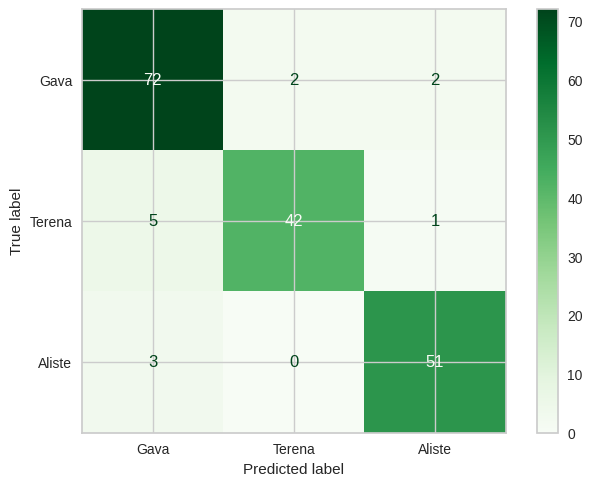

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['Gava', 'Terena', 'Aliste'])
disp.plot(cmap='Greens')
#plt.savefig("./FIGURES/20240826_DestilledVortex2VS1_ConfMatrix.png",bbox_inches='tight')


### Save the Model
This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

In [27]:
save_model(final_model, model_name = '/home/dsg/VORTEX_FINAL/PRODUCTION/models/20250227_VdHSpecific',verbose=True)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Al', 'Si', 'P', 'S', 'Cl', 'K',
                                              'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co',
                                              'Ni', 'Cu', 'Zn', 'As', 'Rb', 'Sr',
                                              'Zr'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               co...
                                                                          class_weight='balanced',
                                                                          criterion='entropy',
                                      